In [1]:
from ROOT import *
import numpy as np
import math
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

Welcome to JupyROOT 6.14/04


/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/ROOT.py:577: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [56]:
# NEW FILE UTUT CONFIG

ch1=TChain("MCParticleNTuple/Tracks")
ch1.Add("~/MightyIT/MCtracks_MagUp_bs2phiphi_1p5e34_20ev.root")

#ch1=TChain("MCParticleNTuple/Tracks")
#ch1.Add("~/MightyIT/MCtracks_MagUp_bs2phiphi_1p5e34_nocuts_20ev.root")


zmag = 5184 #for MCtracks_MagUp_bs2phiphi_1p5e34 WITH UTUT

sigmax_nosm=8.8
sigmay_nosm=3.6
sigmatx_nosm=0.0032
sigmaty_nosm=0.0011

sigmax_wsm=24
sigmay_wsm=3.6
sigmatx_wsm=0.008
sigmaty_wsm=0.02



perc_list = [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
thr_wsm_list = [1.0, 1.11, 1.25, 1.4, 1.6, 1.74, 1.96, 2.26, 2.55, 2.96, 3.48, 4.3, 5.16, 6.25, 7.66, 10.05, 14.79, 22.37, 35.06, 63.99]
thr_nosm_list = [2.15, 2.37, 2.58, 2.8, 3.12, 3.47, 3.94, 4.34, 4.81, 5.41, 6.37, 7.31, 8.5, 10.15, 12.97, 16.83, 22.48, 30.23, 42.01, 71.14]
       


In [3]:
# pixel smearing in mightyIT
resx_mit = 0.1/TMath.Sqrt(12)
resy_mit = 0.4/TMath.Sqrt(12)
# strips smearing outside mightyIT
resx_sf = 0.25/TMath.Sqrt(12)
resy_sf = 0.25/TMath.Cos(5.*TMath.Pi()/180.) #takes into account 5° tilting

In [4]:
#function that checks if a point (format: (x,y)) is inside the MightyIT region

def MightyITregion():
    dx = 540
    dy = 200
    
    polygon = Polygon([(-4*dx,1*dy),(-3*dx,1*dy),(-3*dx,2*dy),(-2*dx,2*dy),(-2*dx,3*dy),(-1*dx,3*dy),(-1*dx,4*dy),
                      (1*dx,4*dy),(1*dx,3*dy),(2*dx,3*dy),(2*dx,2*dy),(3*dx,2*dy),(3*dx,1*dy),(4*dx,1*dy),
                      (4*dx,-1*dy),(3*dx,-1*dy),(3*dx,-2*dy),(2*dx,-2*dy),(2*dx,-3*dy),(1*dx,-3*dy),(1*dx,-4*dy),
                      (-1*dx,-4*dy),(-1*dx,-3*dy),(-2*dx,-3*dy),(-2*dx,-2*dy),(-3*dx,-2*dy),(-3*dx,-1*dy),(-4*dx,-1*dy)])
    return polygon
    
def is_inregion(point):
    point = Point(point[0], point[1])
           
    region = MightyITregion()
    if region.contains(point):
        return True
    else:
        return False
    

In [5]:
def ChiSquareVeloT(xv0, yv0, zv0, xv1, yv1, zv1, xt0, yt0, zt0, xt1, yt1, zt1, zmag, smearing=False):
    
    #gaussian smearing - pixel resolutions x and y according to if in mightyit region or outside
    if smearing == True:
        if (is_inregion([xt0,yt0]) == True):
            xt0 = gRandom.Gaus(xt0,resx_mit)
            yt0 = gRandom.Gaus(yt0,resy_mit)
        else:
            xt0 = gRandom.Gaus(xt0,resx_sf)
            yt0 = gRandom.Gaus(yt0,resy_sf)
            xt0 = gRandom.Gaus(xt0,resx_sf)
            yt0 = gRandom.Gaus(yt0,resy_sf)
            
        if (is_inregion([xt1,yt1]) == True):
            xt1 = gRandom.Gaus(xt1,resx_mit)
            yt1 = gRandom.Gaus(yt1,resy_mit)
        else:
            xt1 = gRandom.Gaus(xt1,resx_sf)
            yt1 = gRandom.Gaus(yt1,resy_sf)
            
 
        
    tyV=(yv1 - yv0)/(zv1 - zv0)
    txV=(xv1 - xv0)/(zv1 - zv0)
    tyT=(yt1 - yt0)/(zt1 - zt0)
    txT=(xt1 - xt0)/(zt1 - zt0)

    #zmag calculations
    xVzmag=xv1+(zmag-zv1)*txV
    yVzmag=yv1+(zmag-zv1)*tyV
       
    
    #chi2 calculations
    txPre=(xt0-xVzmag)/(zt0-zmag)
    tyPre=(yt0-yVzmag)/(zt0-zmag)

    #extrapolated point from zmag to t station, with the same slope of the t track
    xT_ex=xVzmag+(zt0-zmag)*txT
    #from velo to t track with velo slope
    yT_ex=yv1+(zt0-zv1)*tyV
    
    chi2 = (txPre-txT)*(txPre-txT)/sigma2tx+(tyPre-tyT)*(tyPre-tyT)/sigma2ty + (yT_ex-yt0)*(yT_ex-yt0)/sigma2y + (xT_ex-xt0)*(xT_ex-xt0)/sigma2x 


    return chi2, (xT_ex-xt0), (yT_ex-yt0), (txPre-txT), (tyPre-tyT)

In [6]:
def reject_outliers(data, nsigma=3):
    data = np.array(data)
    return data[abs(data - np.mean(data)) < nsigma * np.std(data)]


In [7]:
Nbins=100; nrange=5
chihisto_nosm=TH1F("chihisto_nosm","",Nbins,0, nrange)
chihisto_wsm=TH1F("chihisto_wsm","",Nbins,0, nrange)

histolimx = 50
histolimy = 50
scatterx_nosm=TH1F("scatterx_nosm","",Nbins,-histolimx, +histolimx)
scattery_nosm=TH1F("scattery_nosm","",Nbins,-histolimy, +histolimy)

histolimtx = 0.01
histolimty = 0.01
scattertx_nosm=TH1F("scattertx_nosm","",Nbins,-histolimtx, +histolimtx)
scatterty_nosm=TH1F("scatterty_nosm","",Nbins,-histolimty, +histolimty)

histolimx = 50
histolimy = 50
scatterx_wsm=TH1F("scatterx_wsm","",Nbins,-2*histolimx, +2*histolimx)
scattery_wsm=TH1F("scattery_wsm","",Nbins,-2*histolimy, +2*histolimy)

histolimtx = 0.01
histolimty = 0.01
scattertx_wsm=TH1F("scattertx_wsm","",Nbins,-2*histolimtx, +2*histolimtx)
scatterty_wsm=TH1F("scatterty_wsm","",Nbins,-2*histolimty, +2*histolimty)

In [30]:
######################################
# testing smearing: zmag fine tuning #
######################################

maxNevent = 5000

meansx_nosm = []
meansy_nosm = []
meanstx_nosm = []
meansty_nosm = []

range_as =  np.linspace(5180,5190,4)
for zmag in range_as:
    
    print(zmag)


    list_chi_wsm = []
    list_chi_nosm = []
    list_scx_wsm = []
    list_scx_nosm = []
    list_scy_wsm = []
    list_scy_nosm = []
    list_sctx_wsm = []
    list_sctx_nosm = []
    list_scty_wsm = []
    list_scty_nosm = []

    #TESTING SEARCH WINDOWS
    #after noting an asymmetry in distribution depending on the sign of the charge, the zmag has been found from the data. around 5100
    #fine tuning: looking for the best zmag coordinate to have a symmetric distribution of deltax and deltatx with charge>0

    nEvent = 0
    for event in ch1:
        #selecting some long tracks for event in ch1 and cut for !=0 else division/0
        if (event.HitUTZpos[1]-event.HitUTZpos[0] != 0 and event.HitZpos[1]-event.HitZpos[0] != 0
           and  (event.HitUTZpos[1]>event.HitUTZpos[0]>2000) and (event.HitUTZpos[0]<event.HitUTZpos[1]<3000) and event.HitZpos[1]>event.HitZpos[0]>7000. and event.p > 5000):
            nEvent = nEvent+1
            
            #use fist hit in velo and first hit in UT
            xv0=event.HitUTXpos[0];  yv0 = event.HitUTYpos[0]; zv0 = event.HitUTZpos[0];
            xv1=event.HitUTXpos[1];  yv1 = event.HitUTYpos[1]; zv1 = event.HitUTZpos[1];
            xt0 = event.HitXpos[0]; yt0 = event.HitYpos[0]; zt0 = event.HitZpos[0];
            xt1 = event.HitXpos[1]; yt1 = event.HitYpos[1]; zt1 = event.HitZpos[1];
            vp = event.p

            #testing asymmetry: add if event.qop>0
            if event.qop>0:
                smearing = False

                #sigma squared
                sigma2x=pow(sigmax_nosm,2)
                sigma2y=pow(sigmay_nosm,2)
                sigma2tx=pow(sigmatx_nosm,2)
                sigma2ty=pow(sigmaty_nosm,2)

                chi2_astest = ChiSquareVeloT(xv0, yv0, zv0, xv1, yv1, zv1, xt0, yt0, zt0, xt1, yt1, zt1 , zmag, smearing=smearing)
                chihisto_nosm.Fill(chi2_astest[0])
                list_chi_nosm.append(chi2_astest[0])
                scatterx_nosm.Fill(chi2_astest[1])
                list_scx_nosm.append(chi2_astest[1])
                scattery_nosm.Fill(chi2_astest[2])
                list_scy_nosm.append(chi2_astest[2])
                scattertx_nosm.Fill(chi2_astest[3])
                list_sctx_nosm.append(chi2_astest[3])
                scatterty_nosm.Fill(chi2_astest[4])
                list_scty_nosm.append(chi2_astest[4])

        if(nEvent > maxNevent):
            break


    meansx_nosm.append(np.mean(reject_outliers(list_scx_nosm)))
    meansy_nosm.append(np.mean(reject_outliers(list_scy_nosm)))
    meanstx_nosm.append(np.mean(reject_outliers(list_sctx_nosm)))
    meansty_nosm.append(np.mean(reject_outliers(list_scty_nosm)))






5180.0
5183.333333333333
5186.666666666667
5190.0


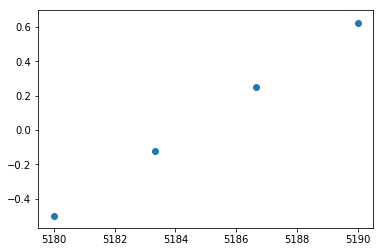

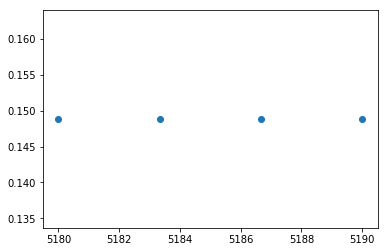

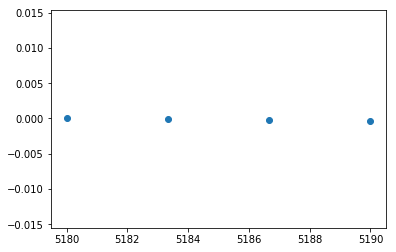

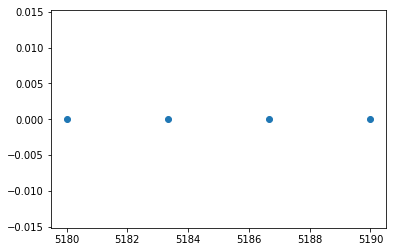

In [31]:
#testing asymmetry, to find zmag fine tuning, 
plt.scatter(range_as,meansx_nosm )
plt.show()
plt.scatter(range_as,meansy_nosm )
plt.show()
plt.scatter(range_as,meanstx_nosm )
plt.show()
plt.scatter(range_as,meansty_nosm )
plt.show()

In [48]:
###################################################
# testing smearing: finding sigmas and thresholds #
###################################################


#update found zmag 

stdsx_nosm = []
stdsy_nosm = []
stdstx_nosm = []
stdsty_nosm = []

stdsx_wsm = []
stdsy_wsm = []
stdstx_wsm = []
stdsty_wsm = []


rangex =range(100000,100001,1) #for chi2 threshold
#rangex =np.linspace(10000,100000,10) #for smearing
for maxNevent in rangex:
    
    print('\n', maxNevent)

    list_chi_wsm = []
    list_chi_nosm = []
    list_scx_wsm = []
    list_scx_nosm = []
    list_scy_wsm = []
    list_scy_nosm = []
    list_sctx_wsm = []
    list_sctx_nosm = []
    list_scty_wsm = []
    list_scty_nosm = []



    #TESTING SEARCH WINDOWS
    #after noting an asymmetry in distribution depending on the sign of the charge, the zmag has been found from the data. around 5100
    #fine tuning: looking for the best zmag coordinate to have a symmetric distribution of deltax and deltatx with charge>0

    nEvent = 0
    for event in ch1:
        #selecting some long tracks for event in ch1 and cut for !=0 else division/0
        if (event.HitVeloZpos[1]-event.HitVeloZpos[0] != 0 and event.HitZpos[1]-event.HitZpos[0] != 0
           and  0.<event.HitVeloZpos[0]<800. and event.HitUTZpos[0]>2000 and event.HitUTZpos[0]<3000 and event.HitZpos[0]>7000. and event.HitZpos[1]>7000 and event.p > 5000):
            nEvent = nEvent+1

            #use fist hit in velo and first hit in UT
            xv0=event.HitUTXpos[0];  yv0 = event.HitUTYpos[0]; zv0 = event.HitUTZpos[0];
            xv1=event.HitUTXpos[1];  yv1 = event.HitUTYpos[1]; zv1 = event.HitUTZpos[1];
            xt0 = event.HitXpos[0]; yt0 = event.HitYpos[0]; zt0 = event.HitZpos[0];
            xt1 = event.HitXpos[1]; yt1 = event.HitYpos[1]; zt1 = event.HitZpos[1];
            vp = event.p

            #testing smearing
            for smearing in [False,True]:

                #change sigmas and windows depending on smearing on/off
                if smearing == False:
                    #sigma squared
                    sigma2x=pow(sigmax_nosm,2)
                    sigma2y=pow(sigmay_nosm,2)
                    sigma2tx=pow(sigmatx_nosm,2)
                    sigma2ty=pow(sigmaty_nosm,2)

                else:
                    #sigma squared
                    sigma2x=pow(sigmax_wsm,2)
                    sigma2y=pow(sigmay_wsm,2)
                    sigma2tx=pow(sigmatx_wsm,2)
                    sigma2ty=pow(sigmaty_wsm,2)

                chi2_smtest = ChiSquareVeloT(xv0, yv0, zv0, xv1, yv1, zv1, xt0, yt0, zt0, xt1, yt1, zt1 , zmag, smearing=smearing)
                if smearing == True:
                    chihisto_wsm.Fill(chi2_smtest[0])
                    list_chi_wsm.append(chi2_smtest[0])
                    scatterx_wsm.Fill(chi2_smtest[1])
                    list_scx_wsm.append(chi2_smtest[1])
                    scattery_wsm.Fill(chi2_smtest[2])
                    list_scy_wsm.append(chi2_smtest[2])
                    scattertx_wsm.Fill(chi2_smtest[3])
                    list_sctx_wsm.append(chi2_smtest[3])
                    scatterty_wsm.Fill(chi2_smtest[4])
                    list_scty_wsm.append(chi2_smtest[4])
                else:
                    chihisto_nosm.Fill(chi2_smtest[0])
                    list_chi_nosm.append(chi2_smtest[0])
                    scatterx_nosm.Fill(chi2_smtest[1])
                    list_scx_nosm.append(chi2_smtest[1])
                    scattery_nosm.Fill(chi2_smtest[2])
                    list_scy_nosm.append(chi2_smtest[2])
                    scattertx_nosm.Fill(chi2_smtest[3])
                    list_sctx_nosm.append(chi2_smtest[3])
                    scatterty_nosm.Fill(chi2_smtest[4])
                    list_scty_nosm.append(chi2_smtest[4])
  
        if(nEvent > maxNevent):
            break
    
    stdsx_nosm.append(np.std(reject_outliers(list_scx_nosm)))
    stdsy_nosm.append(np.std(reject_outliers(list_scy_nosm)))
    stdstx_nosm.append(np.std(reject_outliers(list_sctx_nosm)))
    stdsty_nosm.append(np.std(reject_outliers(list_scty_nosm)))
    
    stdsx_wsm.append(np.std(reject_outliers(list_scx_wsm)))
    stdsy_wsm.append(np.std(reject_outliers(list_scy_wsm)))
    stdstx_wsm.append(np.std(reject_outliers(list_sctx_wsm)))
    stdsty_wsm.append(np.std(reject_outliers(list_scty_wsm)))


('\n', 100000)


In [42]:
#mean of stds after it becomes stable


print 'no smearing'
print(np.mean(stdsx_nosm))
print(np.mean(stdsy_nosm))
print(np.mean(stdstx_nosm))
print(np.mean(stdsty_nosm))

print '\n'
print 'with smearing'
print(np.mean(stdsx_wsm))
print(np.mean(stdsy_wsm))
print(np.mean(stdstx_wsm))
print(np.mean(stdsty_wsm))


no smearing
8.764693032280551
3.5929268835944397
0.003158018249148448
0.0011178190311038985


with smearing
20.63379813081801
3.6092044137740658
0.007611953373796386
0.01836523132576986


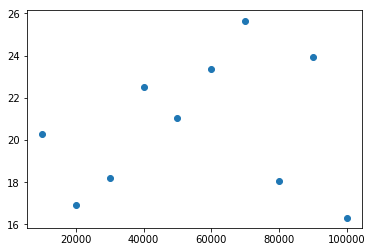

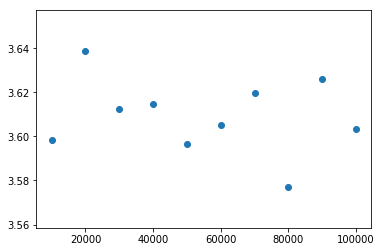

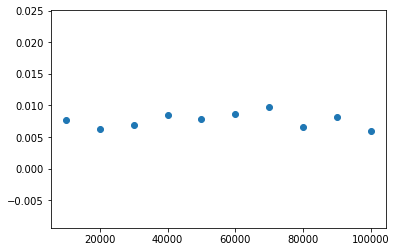

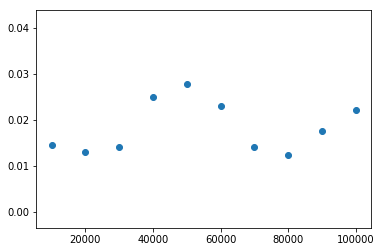

In [44]:
#to find sigmas with and without smearing
plt.scatter(rangex,stdsx_wsm )
plt.show()
plt.scatter(rangex,stdsy_wsm )
plt.show()
plt.scatter(rangex,stdstx_wsm )
plt.show()
plt.scatter(rangex,stdsty_wsm )
plt.show()

In [55]:
#update found sigmas and print the threshold for the chi2 to include a percentage of long track chi2s when cutting below threshold

perc_list = []
thr_wsm_list = []
thr_nosm_list = []

list_chi_wsm.sort()
list_chi_nosm.sort()



print(len(list_chi_wsm))

for percentage in range(80,100):
    threshold_wsm = list_chi_wsm[len(list_chi_wsm)/100*percentage]
    threshold_nosm = list_chi_nosm[len(list_chi_nosm)/100*percentage]
    perc_list.append(percentage)
    thr_wsm_list.append(round(threshold_wsm,2))
    thr_nosm_list.append(round(threshold_nosm,2))
    
    
print(perc_list, thr_nosm_list, thr_wsm_list)

6494
([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [2.15, 2.37, 2.58, 2.8, 3.12, 3.47, 3.94, 4.34, 4.81, 5.41, 6.37, 7.31, 8.5, 10.15, 12.97, 16.83, 22.48, 30.23, 42.01, 71.14], [1.0, 1.11, 1.25, 1.4, 1.6, 1.74, 1.96, 2.26, 2.55, 2.96, 3.48, 4.3, 5.16, 6.25, 7.66, 10.05, 14.79, 22.37, 35.06, 63.99])


In [ ]:
#### PLOTS #####

c9=TCanvas("c9","",1300,900)
chihisto_nosm.SetLineColor(kBlue)
chihisto_nosm.Draw()
chihisto_wsm.SetLineColor(kRed)
chihisto_wsm.Draw("SAME")
c9.SaveAs("dist_chi2_wwo_smearing.png")

In [233]:
#plot deltax, y tx, ty distributions with no smearing



c5=TCanvas("c5","",1300,900)

c5.Divide(2,2)

c5.cd(1)
funcx= TF1("funcx", "gaus", -histolimx, +histolimx)
funcx.SetParameters(500,0,0)
fitresult_x = scatterx_nosm.Fit(funcx)
print(funcx.GetParameter(2))
#scatterx_nosm.Draw()




c5.cd(2)
funcy = TF1("funcy", "gaus", -histolimy, +histolimy)
funcy.SetParameters(500,0,0)
fitresult_y = scattery_nosm.Fit(funcy)
print(funcy.GetParameter(2))
#scattery_nosm.Draw()



c5.cd(3)
funct = TF1("functx", "gaus", -histolimtx, +histolimtx)
functx.SetParameters(500,0,0)
fitresult_tx = scattertx_nosm.Fit(functx)
print(functx.GetParameter(2))
#scattertx_nosm.Draw()

c5.cd(4)
functy = TF1("functy", "gaus", -histolimty, +histolimty)
functy.SetParameters(500,0,0)
fitresult_ty = scatterty_nosm.Fit(functy)
print(functy.GetParameter(2))
scatterty_nosm.Draw()


c5.SaveAs("dist_testing_deltas_nosmearing.png")

34.3907786363
122.151072297
0.0054743794165
0.0367664749103
 FCN=8.02303 FROM MIGRAD    STATUS=CONVERGED     130 CALLS         131 TOTAL
                     EDM=7.73815e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.83251e+00   5.14252e-01   6.00104e-04  -2.16112e-03
   2  Mean         5.62120e+00   1.61281e+01   2.17841e-02  -2.94040e-05
   3  Sigma        3.43908e+01   2.61933e+01   7.10813e-04  -1.68194e-03
 FCN=2.61036 FROM MIGRAD    STATUS=CONVERGED     326 CALLS         327 TOTAL
                     EDM=4.70555e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.56250e+00   2.27570e+00   3.61076e-04   5.87418e-04
   2  Mean         4.78657e+01   1.90018e+02  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Info in <TCanvas::Print>: png file dist_testing_deltas_nosmearing.png has been created


In [365]:
#plot deltax, y tx, ty distributions with smearing



c1=TCanvas("c5","",1300,900)

c1.Divide(2,2)

c1.cd(1)
funcx= TF1("funcx", "gaus", -histolimx, +histolimx)
funcx.SetParameters(500,0,0)
fitresult_x = scatterx_wsm.Fit(funcx)
print(funcx.GetParameter(2))
scatterx_wsm.Draw()




c1.cd(2)
funcy = TF1("funcy", "gaus", -histolimy, +histolimy)
funcy.SetParameters(500,0,0)
fitresult_y = scattery_wsm.Fit(funcy)
print(funcy.GetParameter(2))
scattery_wsm.Draw()



c1.cd(3)
funct = TF1("functx", "gaus", -histolimtx, +histolimtx)
functx.SetParameters(500,0,0)
fitresult_tx = scattertx_wsm.Fit(functx)
print(functx.GetParameter(2))
scattertx_wsm.Draw()

c1.cd(4)
functy = TF1("functy", "gaus", -histolimty, +histolimty)
functy.SetParameters(500,0,0)
fitresult_ty = scatterty_wsm.Fit(functy)
print(functy.GetParameter(2))
scatterty_wsm.Draw()


c1.SaveAs("dist_testing_deltas_smearing.png")

4.28272563778
21.6645034303
0.00154991296567
0.00317805227026
 FCN=17393.4 FROM MIGRAD    STATUS=CONVERGED     108 CALLS         109 TOTAL
                     EDM=1.59655e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.49504e+04   1.19333e+02   5.19613e+00   4.17763e-06
   2  Mean        -2.29140e-02   9.88791e-03   6.36771e-04   1.31703e-04
   3  Sigma        4.28273e+00   1.07688e-02   2.37135e-05   1.50728e+00
 FCN=2825.54 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=3.17518e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.43076e+03   2.17532e+01   4.29445e-01   2.57720e-07
   2  Mean         7.50334e-02   4.82334e-02

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Info in <TCanvas::Print>: png file dist_testing_deltas_smearing.png has been created
